In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = True))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.9444444444444444, Loss: 0.3197645258020472
Checkpoint 200, Accuracy: 0.9506172839506173, Loss: 0.2578560334664804
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.24009987160011573
Checkpoint 400, Accuracy: 0.9506172839506173, Loss: 0.2589913120976201
Checkpoint 500, Accuracy: 0.9382716049382716, Loss: 0.2513591095253273


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.8945213  0.06256043 0.0429182 ]
[1. 0. 0.] <-> [0.9369681  0.01807661 0.04495525]
[1. 0. 0.] <-> [0.8114955  0.1168636  0.07164091]
[1. 0. 0.] <-> [0.9095334  0.01184962 0.07861698]
[1. 0. 0.] <-> [0.8614416  0.0119252  0.12663318]
[1. 0. 0.] <-> [0.87986654 0.06859528 0.05153818]
[1. 0. 0.] <-> [0.9201948  0.03377818 0.04602707]
[1. 0. 0.] <-> [0.8899367  0.07936095 0.03070239]
[0. 0. 1.] <-> [0.09339572 0.00777073 0.8988336 ]
[0. 1. 0.] <-> [0.16010751 0.8362272  0.00366524]
[1. 0. 0.] <-> [0.80718696 0.03569083 0.15712222]
[1. 0. 0.] <-> [0.84566164 0.1303681  0.02397028]
[1. 0. 0.] <-> [0.90438825 0.01187036 0.08374139]
[1. 0. 0.] <-> [0.9238173  0.01065668 0.06552608]
[1. 0. 0.] <-> [0.89174837 0.05262375 0.05562789]
[0. 1. 0.] <-> [0.19339196 0.80367815 0.00292988]
[1. 0. 0.] <-> [0.9054872  0.05911039 0.03540248]
[0. 0. 1.] <-> [0.8855102  0.01420726 0.10028261]
[0. 0. 1.] <-> [0.26094344 0.00913983 0.7299167 ]
[0. 0. 1.] <-> [0.08528571 0.00629103 0.9084233 ]


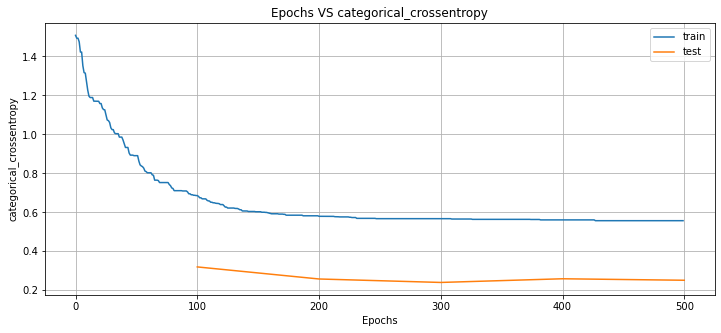

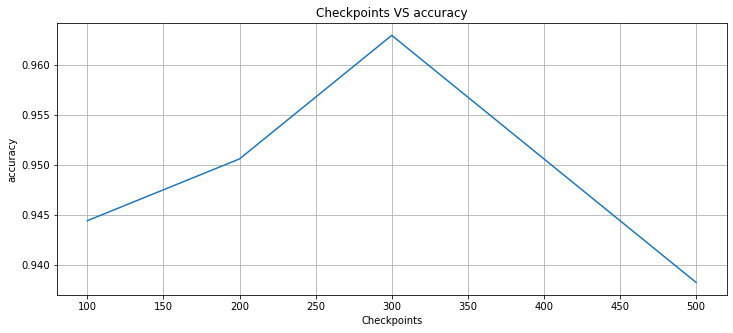

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9444444444444444, 'mean_square_error': 0.150044469982933, 'categorical_crossentropy': 0.3197645258020472, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 9, 'tn_hit': 23, 'fn_hit': 0}, 1: {'tp_hit': 14, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 9, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 6}}, 'checkpoint': 100} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.12417340529948004, 'categorical_crossentropy': 0.2578560334664804, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 8, 'tn_hit': 24, 'fn_hit': 0}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 5}, 2: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 3}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.11078024499445994, 'categorical_crossentropy': 0.24009987160011573, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 6, 'tn_hit': 26, 'fn_hit': 0}, 1: {'tp_hit': 14, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 93, 'fn_

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-0.01081199 -0.17347535 -0.019113   -0.2157382  -0.06920312]
 bias: -0.021239113062620163

Neuron 1: weights:
[-0.65052617  1.1769253   0.48777783 -0.04977696 -0.21138749]
 bias: 0.002154260640963912

Neuron 2: weights:
[-0.5502      1.4192255   0.87312144  0.06678689 -0.04706121]
 bias: -0.8915610909461975

Neuron 3: weights:
[ 0.21264352 -0.00954031  0.7455275   1.9150698   1.2065885 ]
 bias: -0.7501976490020752

$
Layer 2
Neuron 0: weights:
[ 0.40135643 -0.10310876 -0.3167502  -3.        ]
 bias: 2.368333339691162

Neuron 1: weights:
[-0.10244541  3.          3.         -0.11653509]
 bias: -3.0

Neuron 2: weights:
[ 0.12338063 -2.3634572  -0.7254263   1.8738378 ]
 bias: -0.015256206505000591

$

